In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Data/lstm_stock_model.h5', compile=False)


In [3]:
import pickle
# Load scaler from disk
with open('/content/drive/MyDrive/Data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


In [4]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Data/tsla.csv')
data.head()

,Date,Close,High,Low,Open,Volume
0,2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
1,2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2,2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
3,2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
4,2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


In [5]:
data.set_index('Date', inplace=True)

In [6]:
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


In [7]:
data.shape

(2535, 5)

In [8]:
feature_col = 'Close'
n_steps = 10

In [9]:
values = data[[feature_col]].values

In [10]:
scaled = scaler.fit_transform(values)

In [11]:
# 4. Create sequences
def create_sequences(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [12]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [13]:
# Predict on test set
y_pred_test = model.predict(X_test)

# Inverse scale predictions and actual values
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate residuals
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()

# Calculate standard deviation of residuals
std_dev = np.std(residuals)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [14]:
forecast = scaler.inverse_transform(np.array(y_pred_test).reshape(-1, 1))
forecast

array([[261.81375],
       [261.9614 ],
       [255.96754],
       [259.40955],
       [263.14105],
       [260.58737],
       [253.85698],
       [254.09389],
       [252.25922],
       [249.76207],
       [247.64648],
       [242.20055],
       [241.64998],
       [240.81812],
       [238.70132],
       [233.44102],
       [226.3005 ],
       [219.45224],
       [214.86461],
       [222.787  ],
       [228.77582],
       [233.90955],
       [231.47322],
       [234.22548],
       [236.42433],
       [248.10681],
       [253.10654],
       [255.57898],
       [247.4417 ],
       [249.80212],
       [249.97937],
       [249.40863],
       [247.14737],
       [261.02768],
       [263.83905],
       [267.2717 ],
       [271.37546],
       [271.77615],
       [265.22815],
       [262.47006],
       [260.00415],
       [254.86649],
       [245.61206],
       [243.00708],
       [241.78221],
       [239.47514],
       [242.07289],
       [246.2626 ],
       [248.9175 ],
       [246.35617],


In [15]:
n_steps = 10  # match model input
#last_sequence = data[-n_steps:].values.reshape(-1, 1)
last_sequence = data['Close'].values[-n_steps:].reshape(-1, 1)

last_sequence_scaled = scaler.transform(last_sequence)


In [16]:
def forecast_future(model, last_sequence, n_future_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_future_steps):
        # Reshape to match model input: (1, n_steps, 1)
        input_seq = current_sequence.reshape((1, current_sequence.shape[0], 1))
        next_pred = model.predict(input_seq, verbose=0)[0]
        future_predictions.append([next_pred[0]])

        # Append the prediction and slide the window
        current_sequence = np.append(current_sequence[1:], [next_pred], axis=0)

    # Inverse scale predictions to original range
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions.flatten()


In [17]:
n_future_steps = 180
future = forecast_future(model, last_sequence_scaled, n_future_steps, scaler)

In [18]:
# Calculate 95% confidence intervals
upper_bound = forecast.flatten() + 1.96 * std_dev
lower_bound = forecast.flatten() - 1.96 * std_dev


In [23]:
# Flatten and take only last 180 values to match future_dates
forecast = np.array(forecast).flatten()[-180:]
lower_bound = np.array(lower_bound).flatten()[-180:]
upper_bound = np.array(upper_bound).flatten()[-180:]

In [19]:
data.index = pd.to_datetime(data.index)
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


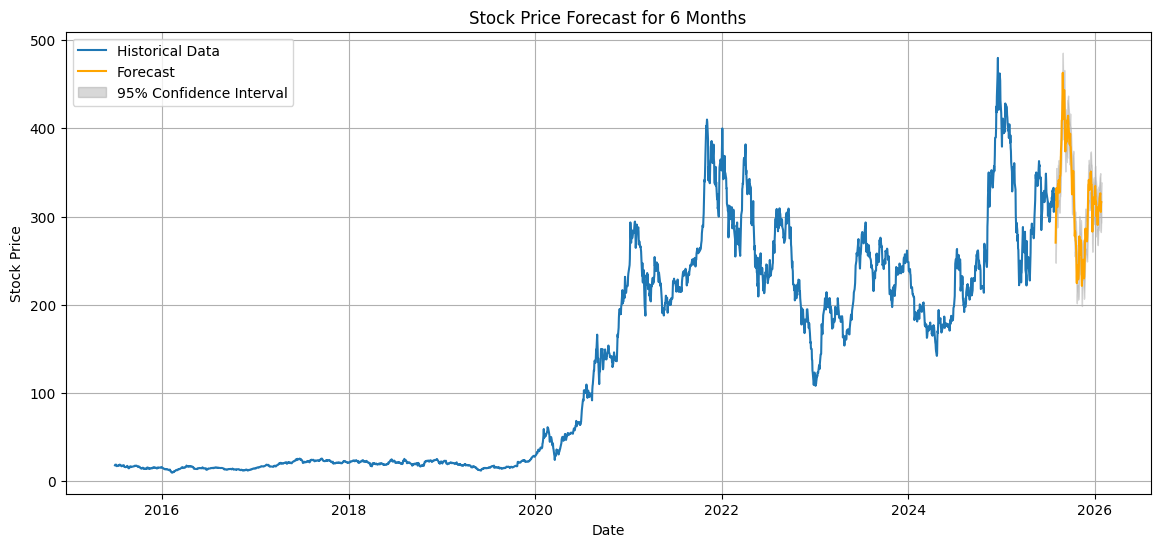

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

# Create future dates
last_date = data.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 181)]

plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(future_dates, forecast, label='Forecast', color='orange')
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title("Stock Price Forecast for 6 Months")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


Interpretation:
### Consistent Volatility

The forecast line oscillates (goes up and down regularly), this means the model expects continued volatility — but within a familiar range.

This can be common in tech stocks like Tesla, where prices often fluctuate around earnings, announcements, or macroeconomic changes.

### No Drastic Trend Change

Since the forecast resembles the last 6 months, there's no expected major upward or downward breakout.

Investors or stakeholders might see this as a period of consolidation or stability.

###Possible Strategy Insight

The forecast could suggest short-term swing trading opportunities or holding off long-term decisions until a clearer breakout is seen.